# Understanding False Discovery Rate (FDR)

When you test many hypotheses at once, you'll get false positives just by chance. False Discovery Rate (FDR) correction helps control how many of your "significant" results are actually wrong.

## Learning Objectives

By the end of this notebook, you will be able to:
1. Understand the multiple testing problem
2. Explain what FDR means in plain language
3. Apply FDR correction using SciPy
4. Decide when you need FDR correction
5. Interpret FDR-corrected results correctly

---

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import false_discovery_control

# Set random seed for reproducibility
np.random.seed(42)

print('Libraries loaded!')

Libraries loaded!


---

## Part 1: The Multiple Testing Problem

### The Coin Flip Analogy

Imagine you flip a fair coin 100 times. Even though the coin is fair, you'll sometimes get streaks of heads or tails just by chance.

**Statistical testing is similar:**
- If you test 100 things with α = 0.05 (5% significance level)
- You'll expect **5 false positives** just by random chance
- These are called **false discoveries**

### Example 1: Testing 100 Genes (None are Real)

Let's simulate testing 100 genes where **none** actually affect disease risk.

In [3]:
# Simulate 100 p-values from null hypothesis (no real effect)
# These p-values should be uniformly distributed
n_tests = 100
null_pvalues = np.random.uniform(0, 1, n_tests)

# Count how many are "significant" at p < 0.05
false_positives = (null_pvalues < 0.05).sum()

print(f'Tested {n_tests} genes (none actually matter)')
print(f'Found {false_positives} "significant" results at p < 0.05')
print(f'Expected: ~{n_tests * 0.05:.0f} false positives')
print(f'\n⚠️ All {false_positives} are FALSE POSITIVES!')

Tested 100 genes (none actually matter)
Found 6 "significant" results at p < 0.05
Expected: ~5 false positives

⚠️ All 6 are FALSE POSITIVES!


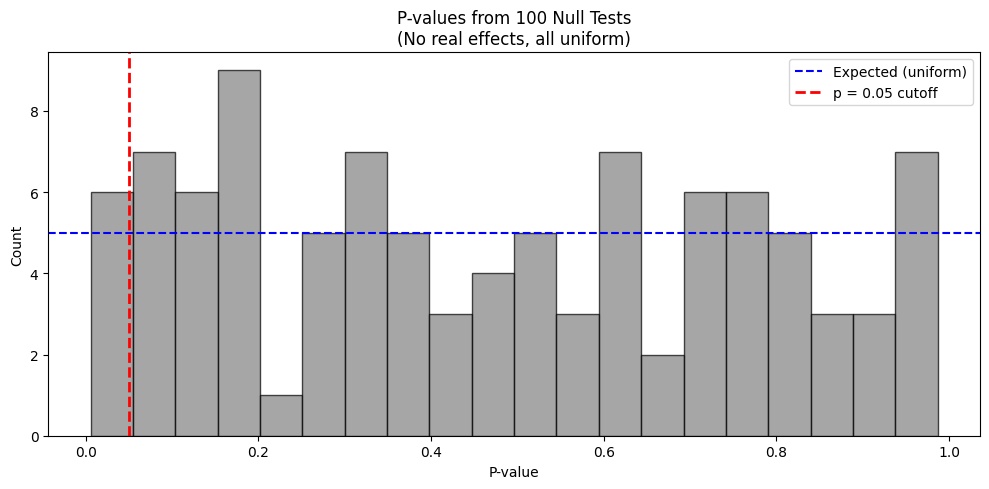

→ P-values are uniformly distributed when there's no real effect


In [4]:
# Visualize the p-values
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(null_pvalues, bins=20, color='gray', alpha=0.7, edgecolor='black')
ax.axhline(n_tests/20, color='blue', linestyle='--', label='Expected (uniform)')
ax.axvline(0.05, color='red', linestyle='--', linewidth=2, label='p = 0.05 cutoff')
ax.set_xlabel('P-value')
ax.set_ylabel('Count')
ax.set_title('P-values from 100 Null Tests\n(No real effects, all uniform)')
ax.legend()
plt.tight_layout()
plt.show()

print('→ P-values are uniformly distributed when there\'s no real effect')

### 📝 Practice Question 1

**Task:** You're testing 500 brain regions for activity during a task, but actually **none** show real activity.

If you use p < 0.05, how many regions would you **expect** to call "significant" by chance?

Calculate: `500 * 0.05 = ?`

In [ ]:
# YOUR CODE HERE
# Calculate expected false positives for 500 tests


## Part 3: Real Example - Gene Expression Study

### Scenario: Cancer vs Normal Tissue

You measure 20 genes in cancer vs normal tissue. Let's create realistic data:
- **5 genes** truly different (real effects)
- **15 genes** no difference (null)

---

## Part 2: What is False Discovery Rate (FDR)?

### Definition (Simple)

**FDR** = The proportion of your "discoveries" that are actually false

```
FDR = False Positives / Total Positives
```

### Example:
- You test 1000 genes
- 50 come back "significant"
- 5 of these are false positives
- **FDR = 5/50 = 0.10 = 10%**

This means: "10% of my discoveries are wrong"

### FDR Control Goal:
Keep FDR below a threshold (usually 5% or 10%)

---

In [ ]:
# Create realistic p-values
# 5 genes with real effects (small p-values)
real_effect_pvalues = np.array([0.001, 0.003, 0.008, 0.012, 0.025])

# 15 genes with no effect (random p-values)
no_effect_pvalues = np.array([0.052, 0.089, 0.123, 0.234, 0.345, 
                               0.456, 0.567, 0.678, 0.789, 0.832,
                               0.891, 0.912, 0.945, 0.967, 0.989])

# Combine all p-values
all_pvalues = np.concatenate([real_effect_pvalues, no_effect_pvalues])

# Gene names
genes = [f'Gene_{i+1}' for i in range(20)]
truth = ['TRUE EFFECT']*5 + ['NO EFFECT']*15

# Create DataFrame
df = pd.DataFrame({
    'gene': genes,
    'p_value': all_pvalues,
    'truth': truth
})

print('Gene expression study results:')
print(df)

### Without FDR Correction - Using p < 0.05

In [ ]:
# Mark as significant using traditional p < 0.05
df['significant_uncorrected'] = df['p_value'] < 0.05

# Count results
uncorrected_sig = df[df['significant_uncorrected']]
true_positives = uncorrected_sig[uncorrected_sig['truth'] == 'TRUE EFFECT']
false_positives = uncorrected_sig[uncorrected_sig['truth'] == 'NO EFFECT']

print('=== Without FDR Correction (p < 0.05) ===')
print(f'Total "significant": {len(uncorrected_sig)}')
print(f'  True positives: {len(true_positives)}')
print(f'  False positives: {len(false_positives)}')

if len(uncorrected_sig) > 0:
    fdr_observed = len(false_positives) / len(uncorrected_sig)
    print(f'\nObserved FDR: {fdr_observed:.2%}')
    print(f'→ {fdr_observed:.0%} of our "discoveries" are wrong!')

### With FDR Correction - Using SciPy

In [ ]:
# Apply FDR correction
fdr_corrected = false_discovery_control(df['p_value'], method='bh')
df['fdr_corrected'] = fdr_corrected
df['significant_fdr'] = fdr_corrected < 0.05

# Count results
fdr_sig = df[df['significant_fdr']]
true_positives_fdr = fdr_sig[fdr_sig['truth'] == 'TRUE EFFECT']
false_positives_fdr = fdr_sig[fdr_sig['truth'] == 'NO EFFECT']

print('=== With FDR Correction (FDR < 0.05) ===')
print(f'Total significant: {len(fdr_sig)}')
print(f'  True positives: {len(true_positives_fdr)}')
print(f'  False positives: {len(false_positives_fdr)}')

if len(fdr_sig) > 0:
    fdr_observed_corrected = len(false_positives_fdr) / len(fdr_sig)
    print(f'\nObserved FDR: {fdr_observed_corrected:.2%}')
    print(f'✓ FDR is now controlled!')

print('\nResults:')
print(df[['gene', 'p_value', 'fdr_corrected', 'significant_fdr', 'truth']])

In [ ]:
# Visualize the difference
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: P-values
colors = ['red' if t == 'TRUE EFFECT' else 'blue' for t in df['truth']]
axes[0].scatter(range(len(df)), df['p_value'], c=colors, s=100, alpha=0.6)
axes[0].axhline(0.05, color='black', linestyle='--', label='p = 0.05')
axes[0].set_xlabel('Gene')
axes[0].set_ylabel('P-value')
axes[0].set_title('Original P-values\n(Red = true effect, Blue = no effect)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: FDR-corrected
axes[1].scatter(range(len(df)), df['fdr_corrected'], c=colors, s=100, alpha=0.6)
axes[1].axhline(0.05, color='black', linestyle='--', label='FDR = 0.05')
axes[1].set_xlabel('Gene')
axes[1].set_ylabel('FDR-corrected p-value')
axes[1].set_title('After FDR Correction\n(Threshold is more stringent)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print('→ FDR correction makes the threshold stricter to control false discoveries')

### 📝 Practice Question 2

**Task:** Look at the results above. How many true positive genes did we **lose** by applying FDR correction?

Calculate: (true positives without correction) - (true positives with correction)

**Discussion:** Is this tradeoff worth it?

In [ ]:
# YOUR CODE HERE
# Count true positives lost


---

## Part 4: Real Biology Examples

Let's see FDR correction in different biological contexts.

### Example 2: Neuroscience - Brain Region Activity

In [ ]:
# Test 50 brain regions for activity during memory task
# 3 regions truly active, 47 not active

active_regions = np.array([0.0001, 0.0008, 0.003])  # 3 truly active
inactive_regions = np.random.uniform(0.05, 0.95, 47)  # 47 not active

brain_pvalues = np.concatenate([active_regions, inactive_regions])
regions = [f'Region_{i+1}' for i in range(50)]

brain_df = pd.DataFrame({
    'region': regions,
    'p_value': brain_pvalues
})

# Apply FDR
brain_df['fdr'] = false_discovery_control(brain_df['p_value'], method='bh')
brain_df['significant'] = brain_df['fdr'] < 0.05

print('=== Brain Activity Study ===')
print(f'Regions tested: {len(brain_df)}')
print(f'Significant (FDR < 0.05): {brain_df["significant"].sum()}')
print('\nSignificant regions:')
print(brain_df[brain_df['significant']][['region', 'p_value', 'fdr']])

### Example 3: Ecology - Species Abundance

In [ ]:
# Test 30 species for abundance differences between habitats
# 4 species truly different, 26 no difference

different_species = np.array([0.002, 0.005, 0.015, 0.028])  # 4 truly different
same_species = np.random.uniform(0.1, 0.9, 26)  # 26 no difference

species_pvalues = np.concatenate([different_species, same_species])
species_names = [f'Species_{i+1}' for i in range(30)]

ecology_df = pd.DataFrame({
    'species': species_names,
    'p_value': species_pvalues
})

# Apply FDR
ecology_df['fdr'] = false_discovery_control(ecology_df['p_value'], method='bh')
ecology_df['significant'] = ecology_df['fdr'] < 0.10  # Using 10% FDR

print('=== Ecology Study (Habitat Comparison) ===')
print(f'Species tested: {len(ecology_df)}')
print(f'Significant (FDR < 0.10): {ecology_df["significant"].sum()}')
print('\nSpecies with different abundances:')
print(ecology_df[ecology_df['significant']][['species', 'p_value', 'fdr']])

### Example 4: Cell Biology - Protein Phosphorylation Sites

In [ ]:
# Test 100 phosphorylation sites for drug response
# 8 sites truly respond, 92 don't

responsive_sites = np.array([0.0001, 0.0003, 0.001, 0.002, 0.005, 0.008, 0.012, 0.018])
non_responsive = np.random.uniform(0.05, 0.95, 92)

sites_pvalues = np.concatenate([responsive_sites, non_responsive])
sites = [f'pSite_{i+1}' for i in range(100)]

phospho_df = pd.DataFrame({
    'site': sites,
    'p_value': sites_pvalues
})

# Compare with and without FDR
phospho_df['fdr'] = false_discovery_control(phospho_df['p_value'], method='bh')
phospho_df['sig_uncorrected'] = phospho_df['p_value'] < 0.05
phospho_df['sig_fdr'] = phospho_df['fdr'] < 0.05

print('=== Phosphoproteomics Study ===')
print(f'Sites tested: {len(phospho_df)}')
print(f'\nWithout FDR (p < 0.05): {phospho_df["sig_uncorrected"].sum()} sites')
print(f'With FDR (FDR < 0.05): {phospho_df["sig_fdr"].sum()} sites')
print(f'\nReduction: {phospho_df["sig_uncorrected"].sum() - phospho_df["sig_fdr"].sum()} false positives removed')

### 📝 Practice Question 3

**Task:** You're testing 200 metabolites for differences between diet groups.

Create synthetic data:
- 10 metabolites with true differences (p-values: 0.0001 to 0.01)
- 190 metabolites with no differences (random p-values: 0.1 to 0.9)

Apply FDR correction and report how many are significant at FDR < 0.05.

In [ ]:
# YOUR CODE HERE
# Create metabolite data and apply FDR correction


---

## Part 5: When Do You Need FDR Correction?

### Decision Guide:

| Number of Tests | Action |
|----------------|--------|
| 1-5 tests | Usually no correction needed |
| 5-20 tests | Consider correction (optional) |
| 20-100 tests | **FDR correction recommended** |
| 100+ tests | **FDR correction essential** |
| 1000+ tests | **FDR correction absolutely required** |

### Real-World Examples:

**✅ Use FDR when:**
- Testing 20,000 genes for expression differences
- Testing 100 brain regions for activity
- Testing 500 metabolites in blood samples
- Testing 50 species across habitats

**❌ Don't need FDR when:**
- Testing one gene for expression
- Comparing two groups with t-test
- Testing pre-specified hypothesis (single test)

---

## Part 6: How to Use FDR in Your Analysis

### Step-by-Step Recipe:

In [ ]:
# Example: Complete workflow
from scipy.stats import ttest_ind, false_discovery_control

# 1. Run your tests and collect p-values
# (Example: testing 50 genes)
np.random.seed(123)
n_genes = 50

# Simulate some data
control = np.random.normal(5, 1, (10, n_genes))  # 10 samples, 50 genes
treatment = np.random.normal(5, 1, (10, n_genes))  # Same (mostly null)

# Make 3 genes truly different
treatment[:, [0, 5, 10]] += 2  # Increase expression in 3 genes

# Run t-tests
gene_names = [f'Gene_{i+1}' for i in range(n_genes)]
pvalues = []

for i in range(n_genes):
    t, p = ttest_ind(control[:, i], treatment[:, i])
    pvalues.append(p)

# 2. Create DataFrame
results = pd.DataFrame({
    'gene': gene_names,
    'p_value': pvalues
})

# 3. Apply FDR correction
results['fdr'] = false_discovery_control(results['p_value'], method='bh')

# 4. Mark significant results
results['significant'] = results['fdr'] < 0.05

# 5. Report results
print('=== Analysis Results ===')
print(f'Total genes tested: {len(results)}')
print(f'Significant (FDR < 0.05): {results["significant"].sum()}')
print('\nSignificant genes:')
print(results[results['significant']])

### 📝 Practice Question 4 (Final Challenge)

**Task:** You're comparing gene expression in 3 conditions (healthy, disease_A, disease_B).

You test 100 genes and get these p-value counts:
- Healthy vs Disease_A: 100 p-values
- Healthy vs Disease_B: 100 p-values  
- Disease_A vs Disease_B: 100 p-values

**Total: 300 p-values**

Generate synthetic data (10 true effects in each comparison, rest null) and apply FDR correction to all 300 p-values together.

**Important:** Apply FDR to ALL tests combined, not separately!

In [ ]:
# YOUR CODE HERE
# Create 3 comparisons with 100 tests each
# Combine all p-values and apply FDR correction


---

## Summary

### Key Concepts:

**1. The Problem:**
- Testing multiple hypotheses → get false positives by chance
- At p < 0.05, expect 5% false positives
- With 100 tests, that's ~5 false discoveries!

**2. The Solution:**
- FDR correction controls the proportion of false discoveries
- Most common method: Benjamini-Hochberg (BH)
- Use `false_discovery_control()` from SciPy

**3. How It Works:**
```python
from scipy.stats import false_discovery_control

# Adjust p-values
fdr_pvalues = false_discovery_control(original_pvalues, method='bh')

# Test at FDR threshold (usually 0.05 or 0.10)
significant = fdr_pvalues < 0.05
```

**4. Interpretation:**
- FDR < 0.05 means: "Less than 5% of discoveries are expected to be false"
- More stringent than uncorrected p-values
- Balances sensitivity (finding true effects) vs specificity (avoiding false positives)

**5. When to Use:**
- **Always** when testing >20 hypotheses
- Genomics (thousands of genes)
- Neuroimaging (hundreds of brain regions)
- Metabolomics (hundreds of metabolites)
- Ecological surveys (many species)

### Common Thresholds:
- **FDR < 0.05** (5%): Standard for most studies
- **FDR < 0.10** (10%): More lenient, exploratory studies
- **FDR < 0.01** (1%): Very stringent, high-stakes studies

### Remember:
1. **Collect all p-values first**, then apply FDR to all at once
2. FDR adjusts p-values upward (makes them larger/more conservative)
3. Some true effects may be lost, but false positives are controlled
4. This is the **right tradeoff** for reliable science!

---

### Further Reading:
- Benjamini & Hochberg (1995): Original FDR paper
- `scipy.stats.false_discovery_control` documentation
- "Multiple testing" chapter in statistics textbooks